# 1. CNN Semua

## 1.1 Loading lib and data

In [1]:
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
# Loading all the data from dataset
import pandas as pd
import numpy as np

DATA_PATH = '/kaggle/input/logmel-mfcc-set/'
# DATA_PATH = '/kaggle/input/mfcc-no-filtering/'

# ===== Dataset Notes =====
# ```
# Ver 6 logmel-mfcc-set = MFCC 13, LOGMEL 128, Group_Delay, Wav2Vec2
# Ver 5 logmel-mfcc-set = MFCC 40 with augmentation
# Ver 4 logmel-mfcc-set = MFCC 40
# Ver 1 logmel-mfcc-set = MFCC & Logmel 13
#
# CURRENTLY IN: Version 1
# ```

# =========== MFCC ===========
X_train_mfcc = pd.read_pickle(DATA_PATH + 'X_train_mfcc.pkl')
X_dev_mfcc = pd.read_pickle(DATA_PATH + 'X_dev_mfcc.pkl')
X_eval_mfcc = pd.read_pickle(DATA_PATH + 'X_eval_mfcc.pkl')

y_train_mfcc = pd.read_pickle(DATA_PATH + 'y_train_mfcc.pkl')
y_dev_mfcc = pd.read_pickle(DATA_PATH + 'y_dev_mfcc.pkl')
y_eval_mfcc = pd.read_pickle(DATA_PATH + 'y_eval_mfcc.pkl')

# ============================ SEPARATOR mfcc 40 no filtering ============================
n_mfcc = 40
filters = 'sf'  # 'sf', 'wf', or 'swf'

# Construct file names dynamically
file_suffix = f"_wo_{filters}_{n_mfcc}.pkl"

# X_train_mfcc = pd.read_pickle(DATA_PATH + 'X_train_mfcc_wo_swf.pkl')
# X_dev_mfcc = pd.read_pickle(DATA_PATH + 'X_dev_mfcc_wo_swf.pkl')
# X_eval_mfcc = pd.read_pickle(DATA_PATH + 'X_eval_mfcc_wo_swf.pkl')

# y_train_mfcc = pd.read_pickle(DATA_PATH + 'y_train_mfcc_wo_swf.pkl')
# y_dev_mfcc = pd.read_pickle(DATA_PATH + 'y_dev_mfcc_wo_swf.pkl')
# y_eval_mfcc = pd.read_pickle(DATA_PATH + 'y_eval_mfcc_wo_swf.pkl')

In [3]:
X_train_mfcc = X_train_mfcc.astype('float32')
y_train_mfcc = y_train_mfcc.astype('float32')
X_dev_mfcc = X_dev_mfcc.astype('float32')
y_dev_mfcc = y_dev_mfcc.astype('float32')
X_eval_mfcc = X_eval_mfcc.astype('float32')
y_eval_mfcc = y_eval_mfcc.astype('float32')

## 1.2 EER Calculation

In [9]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
def eval_metr(y_true, y_pred, P_target=0.5):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate (Miss Rate)

    # Compute EER
    abs_diff = np.abs(fpr - fnr)
    eer_index = np.argmin(abs_diff)
    eer = (fpr[eer_index] + fnr[eer_index]) / 2

    return eer

## 1.3 Initializing CNN, Training, and Evaluating

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D,SpatialDropout2D,
    Flatten, Activation, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Fix overfit / overconfident
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Loss

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, dtype=K.floatx())
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = K.pow(1 - p_t, gamma)
        return alpha * focal_term * bce
    return loss

def build_model(input_shape=(100, 40, 1)):
    input_layer = Input(shape=input_shape)
    
    # Deeper CNN with L2 Regularization and Spatial Dropout
    x = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = SpatialDropout2D(0.2)(x)  # New Spatial Dropout

    x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Increased dropout for stronger regularization
    output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

def cnn_maker(X_train, y_train, X_dev, y_dev, X_eval, y_eval):
    X_train, X_dev, X_eval = [x[..., np.newaxis] for x in [X_train, X_dev, X_eval]]

    model = build_model(X_train.shape[1:])
    model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])
    
    callback = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        ModelCheckpoint(f"cnn.keras", monitor='val_loss', save_best_only=True, verbose=1)
    ]
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=4, validation_data=(X_dev, y_dev),
                        callbacks=callback)

    # Model evaluation
    dev_acc = model.evaluate(X_dev, y_dev, verbose=0)[1]
    eval_acc = model.evaluate(X_eval, y_eval, verbose=0)[1]
    
    # Predictions for evaluation
    y_pred_probs = model.predict(X_eval).flatten()
    y_pred_labels = (y_pred_probs > 0.5).astype(int)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_eval, y_pred_labels, target_names=["spoof", "bonafide"], digits=2))

    # Compute EER
    eer = eval_metr(y_eval, y_pred_probs)
    print(f"EER: {eer * 100:.2f}%")

    return model, history


def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train vs Val Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Val Accuracy')
    plt.legend()

    plt.show()

In [6]:
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
# del cnn_mfcc_model
cnn_mfcc_model, history = cnn_maker(X_train_mfcc, y_train_mfcc, X_dev_mfcc, y_dev_mfcc, X_eval_mfcc, y_eval_mfcc)

Epoch 1/50
5383/5395 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8475 - loss: 0.1379
Epoch 1: val_loss improved from inf to 0.03295, saving model to cnn.keras
5395/5395 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - accuracy: 0.8476 - loss: 0.1378 - val_accuracy: 0.9748 - val_loss: 0.0329 - learning_rate: 1.0000e-04
Epoch 2/50
5395/5395 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9573 - loss: 0.0301
Epoch 2: val_loss improved from 0.03295 to 0.01211, saving model to cnn.keras
5395/5395 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9573 - loss: 0.0301 - val_accuracy: 0.9920 - val_loss: 0.0121 - learning_rate: 1.0000e-04
Epoch 3/50
5391/5395 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9792 - loss: 0.0140
Epoch 3: val_loss improved from 0.01211 to 0.00772, saving model to cnn.keras
5395/5395 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9792 - loss: 0.0140 - val_accuracy: 0.9966 - val_loss: 0.0077 - learning_rate: 1.0000e-04
Epoch 4/50
5381/5395 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accura

In [13]:
cnn_mfcc_model.save("cnn_40_no_wf_optimized.keras")

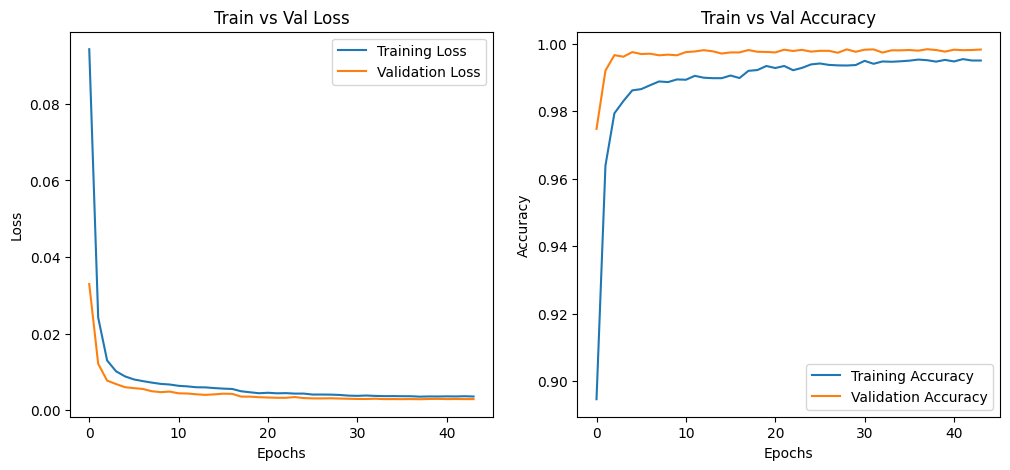

In [7]:
plot_training_history(history)

In [ ]:
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Evaluate the model and get the predicted probabilities
y_pred_dev = cnn_mfcc_model.predict(X_dev_mfcc)  # Get the predicted probabilities for eval data
y_pred_dev_probs_cnn_mfcc = y_pred_dev[:, 0]  # Probability for the positive class (class 1)

roc_auc = roc_auc_score(y_dev_mfcc, y_pred_dev_probs_cnn_mfcc)
print(f'ROC AUC: {roc_auc}')
print(classification_report(y_dev_mfcc, (y_pred_dev_probs_cnn_mfcc >= 0.5).astype(int)))

# Evaluate the metrics using eval_metr
eer_cnn_mfcc_dev = eval_metr(y_dev_mfcc, y_pred_dev_probs_cnn_mfcc)

# Print the results
print(f"CNN EER on validation data: {eer_cnn_mfcc_dev * 100:.2f}%")

In [ ]:
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Evaluate the model and get the predicted probabilities
y_pred_eval = cnn_mfcc_model.predict(X_eval_mfcc)  # Get the predicted probabilities for eval data
y_pred_eval_probs_cnn_mfcc = y_pred_eval[:, 0]  # Probability for the positive class (class 1)

roc_auc = roc_auc_score(y_eval_mfcc, y_pred_eval_probs_cnn_mfcc)
print(f'ROC AUC: {roc_auc}')
print(classification_report(y_eval_mfcc, (y_pred_eval_probs_cnn_mfcc >= 0.5).astype(int)))

# Evaluate the metrics using eval_metr
eer_cnn_mfcc_eval = eval_metr(y_eval_mfcc, y_pred_eval_probs_cnn_mfcc)

# Print the results
print(f"CNN EER on testing data: {eer_cnn_mfcc_eval * 100:.2f}%")

# 2. CNN Each System_ID

In [6]:
import os
import numpy as np
import pandas as pd
import ast
import random
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## 2.1 Function to load data & EER calc

In [10]:
def load_separate_data(base_path, selected_systems):
    all_data = []
    for system_id in ["bonafide"] + [f"A{str(i).zfill(2)}" for i in range(1, 20)]:
        if system_id not in selected_systems:
            continue  # Skip unselected system_ids
        
        file_path = os.path.join(base_path, f"{system_id}.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            all_data.append(df)

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame(columns=["system_id", "features", "label"]) 

# Convert features from string to numpy arrays
def process_features(features_column):
    processed_features = []

    for f in features_column:
        feature_array = np.array(eval(f), dtype=np.float32)  # Convert string to NumPy array
        feature_array = feature_array.reshape(40, 100)  # Reshape to (40, 100)
        processed_features.append(feature_array)

    return np.array(processed_features, dtype=np.float32)

# Split the dataset
def prepare_data(df, bonafide_df, test_size=0.2, val_size=0.1):
    spoof_df = df[df["label"] == 0]
    bonafide_df = bonafide_df.sample(n=len(spoof_df), replace=True)  # Balance bonafide count

    df_balanced = pd.concat([spoof_df, bonafide_df]).sample(frac=1)  # Shuffle

    features = process_features(df_balanced["features"])
    labels = df_balanced["label"].values

    X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=(test_size + val_size), stratify=labels)
    X_dev, X_eval, y_dev, y_eval = train_test_split(X_temp, y_temp, test_size=(val_size / (test_size + val_size)), stratify=y_temp)

    return X_train, y_train, X_dev, y_dev, X_eval, y_eval

from sklearn.metrics import classification_report, roc_auc_score, roc_curve
def eval_metr(y_true, y_pred, P_target=0.5):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fnr = 1 - tpr  # False Negative Rate (Miss Rate)

    # Compute EER
    abs_diff = np.abs(fpr - fnr)
    eer_index = np.argmin(abs_diff)
    eer = (fpr[eer_index] + fnr[eer_index]) / 2
    return eer

## 2.2 Model Arch

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D,SpatialDropout2D,
    Flatten, Activation, Add
)

# CNN Model
def build_model(input_shape=(100, 40, 1)):
    input_layer = Input(shape=input_shape)
    
    # Deeper CNN
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D()(x)
    x = Dense(32, activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)  # Reduced dropout for better learning
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

## 2.3 Training and evaluation functions

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Fix overfit / overconfident
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.losses import Loss

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, dtype=K.floatx())
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = K.pow(1 - p_t, gamma)
        return alpha * focal_term * bce
    return loss

def train_and_evaluate(X_train, y_train, X_dev, y_dev, X_eval, y_eval, system_id):
    X_train, X_dev, X_eval = [x[..., np.newaxis] for x in [X_train, X_dev, X_eval]]

    model = build_model(X_train.shape[1:])
    model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss="binary_crossentropy", metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=15, batch_size=4, validation_data=(X_dev, y_dev))

    # Model evaluation
    dev_acc = model.evaluate(X_dev, y_dev, verbose=0)[1]
    eval_acc = model.evaluate(X_eval, y_eval, verbose=0)[1]
    
    # Predictions for evaluation
    y_pred_probs = model.predict(X_eval).flatten()
    y_pred_labels = (y_pred_probs > 0.5).astype(int)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_eval, y_pred_labels, target_names=["spoof", "bonafide"], digits=2))

    # Compute EER & t-DCF
    eer = eval_metr(y_eval, y_pred_probs)
    print(f"EER: {eer:.4f}")

    return model


def plot_training_history(history, system_id):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train vs Val Loss on {system_id}')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Train vs Val Accuracy on {system_id}')
    plt.legend()

    plt.show()

## 2.4 Running all

In [13]:
base_path = "/kaggle/input/mfcc-sid"
df_bonafide = pd.read_csv(f"{base_path}/bonafide.csv")
selected_systems = ["A01", "A02", "A03", "A04", "A05", "A06", "A07", "A08", "A09", "A10"]
df = load_separate_data(base_path, selected_systems)

for system_id in df["system_id"].unique():
    print(f"\n🔹 Training for {system_id} 🔹")
    
    df_filtered = df[df["system_id"] == system_id]
    
    X_train, y_train, X_dev, y_dev, X_eval, y_eval = prepare_data(df_filtered, df_bonafide)

    model, history = train_and_evaluate(X_train, y_train, X_dev, y_dev, X_eval, y_eval, system_id)

    # plot_training_history(history, system_id)
    
    # Free up memory after training
    del model  
    K.clear_session()


🔹 Training for A01 🔹
Epoch 1/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9345 - loss: 0.2124 - val_accuracy: 1.0000 - val_loss: 0.0112
Epoch 2/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9971 - loss: 0.0215 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 3/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9986 - loss: 0.0082 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 4/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9992 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 6.6134e-04
Epoch 5/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 6.8149e-04
Epoch 6/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 3.4569e-04
Epoch 7/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9988 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 7.0945e-04
Epoch 8/15
2631/2631 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/st

In [ ]:
base_path = "/kaggle/input/mfcc-sid"
selected_systems = ["A11", "A12", "A13", "A14", "A15", "A16", "A17", "A18", "A19"]
df_bonafide = pd.read_csv(f"{base_path}/bonafide.csv")
df = load_separate_data(base_path, selected_systems)

for system_id in df["system_id"].unique():
    print(f"\n🔹 Training for {system_id} 🔹")
    
    df_filtered = df[df["system_id"] == system_id]
    
    X_train, y_train, X_dev, y_dev, X_eval, y_eval = prepare_data(df_filtered, df_bonafide)

    model, history = train_and_evaluate(X_train, y_train, X_dev, y_dev, X_eval, y_eval, system_id)

    # plot_training_history(history, system_id)
    
    # Free up memory after training
    del model  
    K.clear_session()


🔹 Training for A11 🔹
Epoch 1/15
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9009 - loss: 0.3002 - val_accuracy: 0.9995 - val_loss: 0.0312
Epoch 2/15
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9962 - loss: 0.0397 - val_accuracy: 1.0000 - val_loss: 0.0088
Epoch 3/15
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9979 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 4/15
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9989 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 5/15
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9995 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 6/15
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 6.7924e-04
Epoch 7/15
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 8/15
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accurac